<a href="https://colab.research.google.com/github/JaneSams/Fake-News-Project/blob/main/Fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Problem:** 
With the fast global world we have news streaming fast between all social networks and to online news websites, where the competition is measuring who will get it faster and better. Naturally fake news was a by-product of that situation and by other factors (such as political interests etc). 

**Goal**: Create an automatic tool based on machine and deep learning that will classify every new item if it’s a True/False news. The tool can be added to every online newspaper (Ynet for example) or any social network that wants to invalidate fake news  for increasing their credibility to their audience.

# Importing liabries and Data Understanding

In [98]:
# Imports relevant modules
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#general tools
import numpy as np
import pandas as pd
import scipy as sp
from numpy import mean

#SKL
from sklearn.preprocessing import LabelEncoder

#visualization
import matplotlib.pyplot as plt
from plotly.offline import iplot
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score ,StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, fbeta_score, matthews_corrcoef, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.preprocessing.text import one_hot
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pydot



The data comes from Kaggle, you can download it here: https://www.kaggle.com/competitions/fake-news/data

In [99]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [101]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c fake-news

 88% 41.0M/46.5M [00:00<00:00, 47.9MB/s]
100% 46.5M/46.5M [00:00<00:00, 54.4MB/s]


In [7]:
!unzip fake-news.zip

Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


In [8]:
from pathlib import Path
import os

In [9]:
def read_data(filename,**kwargs):
    raw_data=pd.read_csv(filename,**kwargs)
    return raw_data

In [10]:
# Setup Directory Path

root_dir = str(Path().resolve())
input_dir = root_dir+"/input/"
if not os.path.isdir(input_dir):
    os.mkdir(input_dir)
output_dir = root_dir+"/output/"
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
model_dir = root_dir+"/model/"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
image_dir = 'images/'
print(root_dir)

/content


# **READ DATA**

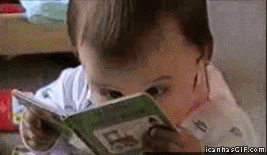

In [124]:

news_df= read_data("train.csv")

submit_test = read_data('test.csv')
submit_label = read_data('submit.csv')
submit_test['label'] = submit_label.label
print(" Shape of News data :: ", news_df.shape)
print(" News data columns", news_df.columns)
print(" Test columns", submit_test.columns)
news_df.head()

 Shape of News data ::  (20800, 5)
 News data columns Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
 Test columns Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [125]:
news=news_df # for original data frame

In [126]:
submit_test.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


In [127]:
submit_label.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


id: unique id for a news article

title: the title of a news article

author: author of the news article

text: the text of the article; could be incomplete

label: a label that marks the article as potentially unreliable

1: unreliable

0: reliable

In [128]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [129]:
news_df.loc[news_df['id']==788]


,id,title,author,text,label
788,788,Women won't earn the same as men for another t...,NaN,"Thu, 27 Oct 2016 11:40 UTC © Joshua Lott / Reu...",1


In [130]:
news_df.loc[news_df['id']==175]

,id,title,author,text,label
175,175,Spider-pig Found in Amazon Rain Forest,NaN,"Sunday, 30 October 2016 Spider-pig fever hits ...",1


In [131]:
news_df.loc[news_df['id']==0]

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1


The classes in the dataset are balanced

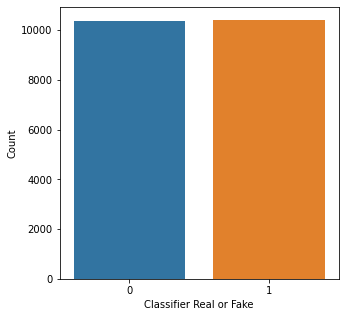

In [132]:
# Visualizing the count of 'Label' column from the dataset

plt.figure(figsize=(5,5))
sns.countplot(x='label', data=news_df)
plt.xlabel('Classifier Real or Fake')
plt.ylabel('Count')
plt.show()


In [133]:
news_df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

We’ll take a look at the number of characters present in each title and new’s text by the label. This can give us a rough idea about the news headline length.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1a55fb9d0>,
      dtype=object)

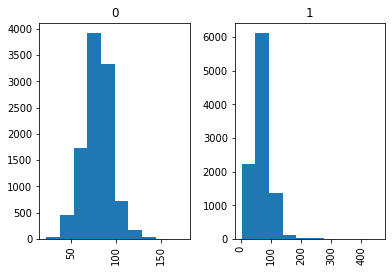

In [134]:
#  the number of characters present in each title by labels
news_df['title'].str.len().hist(by=news_df['label'])

In [135]:
news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [136]:
# merging the author name and news title
news_df['content'] = news_df['author']+' '+news_df['title']

In [137]:
total_df=news_df #for checking all data frame

# **Data Cleaning**

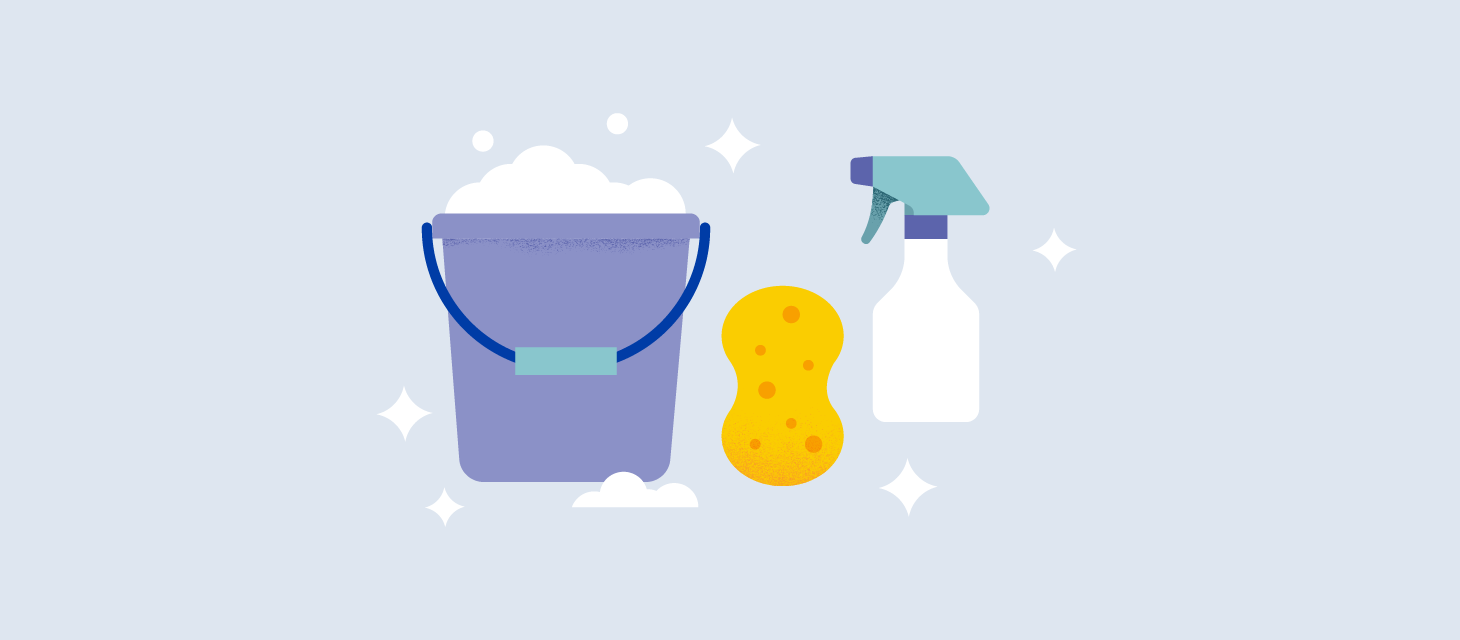

Handling of Null value

Remove special characters

Remove stop words



In [138]:
# replacing the null values with empty string
news_df = news_df.fillna('')
# checking the number of missing values in the dataset
news_df.isnull().sum()

id         0
title      0
author     0
text       0
label      0
content    0
dtype: int64

In [139]:
#Remove special characters
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [140]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
news_df['title_wo_punct']=news_df['title'].apply(lambda x: remove_punctuation(x))
news_df.head()

,id,title,author,text,label,content,title_wo_punct
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...,House Dem Aide We Didn’t Even See Comey’s Lett...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...",FLYNN Hillary Clinton Big Woman on Campus Bre...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...,Why the Truth Might Get You Fired
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...,Iranian woman jailed for fictional unpublished...


In [141]:

def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
news_df['content']=news_df['content'].apply(lambda x: remove_punctuation(x))



Stopwords are the words that are most commonly used in any language such as “the”,” a”,” an” etc.  Since we are only dealing with English news we will filter the English stopwords 

In [142]:
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [143]:
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

In [ ]:
stop_words

In [144]:
## Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')      # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')          # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()   
    return text

In [145]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [146]:
## Nltk Preprocessing include:
# Stop words,
# Stemming 
# For our project we use only Stop word removal
def nltk_preprocesing(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    #text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    #text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text


# news_df["text"] = news_df.text.apply(nltk_preprocesing)
# news_df["title"] = news_df.title.apply(nltk_preprocesing)
news_df['content'] = news_df.content.apply(nltk_preprocesing)
# news_df['author']=news_df.author.apply(nltk_preprocesing)
news_df['title_wo_punct']=news_df['title_wo_punct'].apply(nltk_preprocesing)

In [147]:
#text without punctuation
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct


    
news_df['text_wo_punct']=news_df['text'].apply(lambda x: remove_punctuation(x))
news_df.head()

,id,title,author,text,label,content,title_wo_punct,text_wo_punct
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,darrell lucus house dem aide didnt even see co...,house dem aide didnt even see comeys letter ja...,House Dem Aide We Didn’t Even See Comey’s Lett...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,daniel j flynn flynn hillary clinton big woman...,flynn hillary clinton big woman campus breitbart,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,consortiumnewscom truth might get fired,truth might get fired,Why the Truth Might Get You Fired October 29 2...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,jessica purkiss 15 civilian killed single u ai...,15 civilian killed single u airstrike identified,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,howard portnoy iranian woman jailed fictional ...,iranian woman jailed fictional unpublished sto...,Print \nAn Iranian woman has been sentenced to...


In [148]:
news_df.loc[news_df['id']==788]

,id,title,author,text,label,content,title_wo_punct,text_wo_punct
788,788,Women won't earn the same as men for another t...,,"Thu, 27 Oct 2016 11:40 UTC © Joshua Lott / Reu...",1,,woman wont earn men another two century report,Thu 27 Oct 2016 1140 UTC © Joshua Lott Reuter...


In [149]:
news_df.loc[news_df['id']==175]

,id,title,author,text,label,content,title_wo_punct,text_wo_punct
175,175,Spider-pig Found in Amazon Rain Forest,,"Sunday, 30 October 2016 Spider-pig fever hits ...",1,,spiderpig found amazon rain forest,Sunday 30 October 2016 Spiderpig fever hits ha...


In [36]:
# # Remove column "id"
# news_df = news_df.drop(['id'],axis=1)

In [150]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Exploratory Data Analysis**

Lets Take a look at the Word Clouds for the Titles

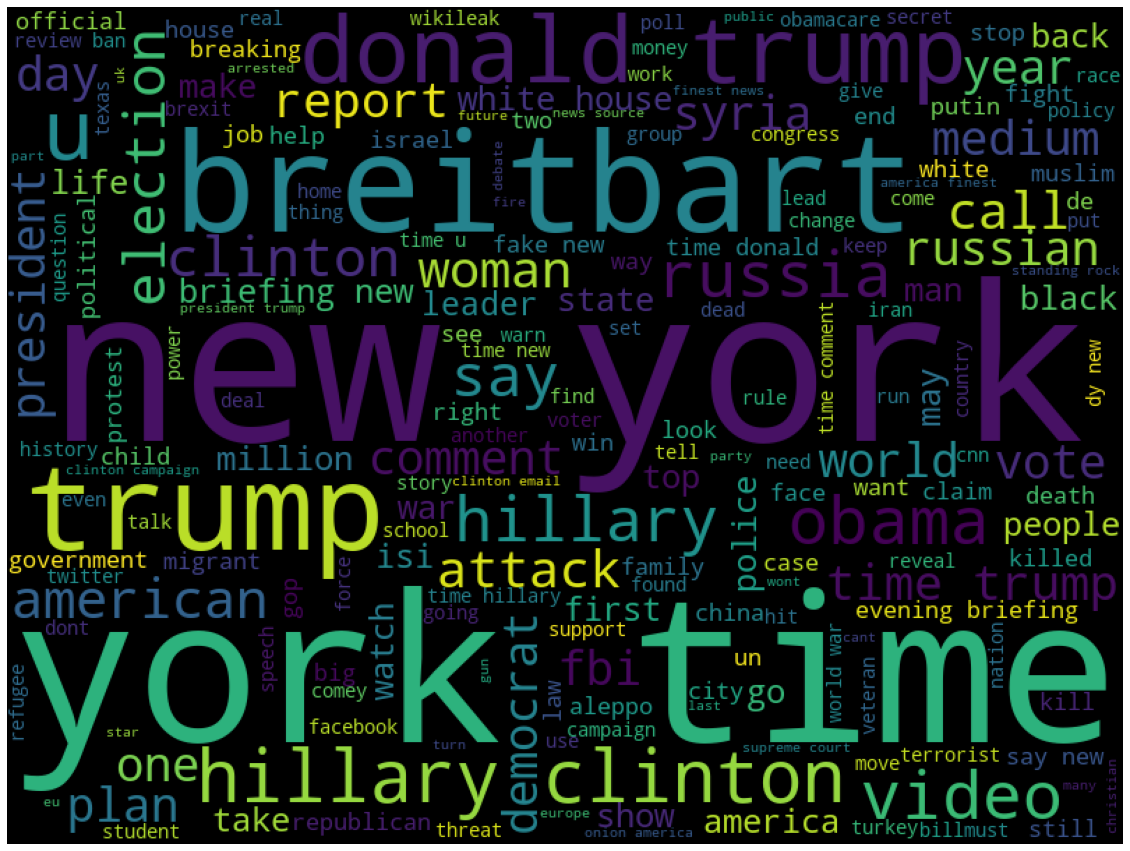

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud( background_color='black', width=800, height=600)

text_cloud = wordcloud.generate(' '.join(news_df['title_wo_punct']))

plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

In [ ]:
news_df_true = news_df.loc[news_df['label'] == 0]
news_df_false = news_df.loc[news_df['label'] == 1]

In [ ]:
news_df_false

,id,title,author,text,label,content,title_wo_punct,text_wo_punct
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,darrell lucus house dem aide didnt even see co...,house dem aide didnt even see comeys letter ja...,House Dem Aide We Didn’t Even See Comey’s Lett...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,consortiumnewscom truth might get fired,truth might get fired,Why the Truth Might Get You Fired October 29 2...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,jessica purkiss 15 civilian killed single u ai...,15 civilian killed single u airstrike identified,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,howard portnoy iranian woman jailed fictional ...,iranian woman jailed fictional unpublished sto...,Print \nAn Iranian woman has been sentenced to...
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,,Ever wonder how Britain’s most iconic pop pian...,1,,life life luxury elton john 6 favorite shark p...,Ever wonder how Britain’s most iconic pop pian...
...,...,...,...,...,...,...,...,...
20788,20788,Maine’s Gov. LePage Threatens To ‘Investigate’...,Joe Clark,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,joe clark maine gov lepage threatens investiga...,maine gov lepage threatens investigate college...,Google Pinterest Digg Linkedin Reddit Stumbleu...
20791,20791,Lawyer Who Kept Hillary Campaign Chief Out of ...,Daniel Greenfield,Lawyer Who Kept Hillary Campaign Chief Out of ...,1,daniel greenfield lawyer kept hillary campaign...,lawyer kept hillary campaign chief jail doj hi...,Lawyer Who Kept Hillary Campaign Chief Out of ...
20793,20793,Idiot Who Destroyed Trump Hollywood Star Gets ...,Robert Rich,Share This \nAlthough the vandal who thought i...,1,robert rich idiot destroyed trump hollywood st...,idiot destroyed trump hollywood star get exact...,Share This \nAlthough the vandal who thought i...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,alex ansary nato russia hold parallel exercise...,nato russia hold parallel exercise balkan,NATO Russia To Hold Parallel Exercises In Balk...


In [ ]:
# Ngram analysis function
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [ ]:
get_top_ngram(news_df_false['text_wo_punct'],1)

[('the', 381426),
 ('to', 179909),
 ('of', 179501),
 ('and', 165786),
 ('in', 120471),
 ('that', 89786),
 ('is', 81760),
 ('for', 58249),
 ('it', 53255),
 ('on', 47851)]

In [ ]:
get_top_ngram(news_df_true['text_wo_punct'],1)

[('the', 538553),
 ('to', 245756),
 ('of', 238365),
 ('and', 216367),
 ('in', 189810),
 ('that', 127608),
 ('for', 86234),
 ('on', 82646),
 ('he', 76053),
 ('is', 74994)]

In [ ]:
get_top_ngram(news_df['text_wo_punct'],1)

[('the', 919979),
 ('to', 425665),
 ('of', 417866),
 ('and', 382153),
 ('in', 310281),
 ('that', 217394),
 ('is', 156754),
 ('for', 144483),
 ('on', 130497),
 ('it', 124152)]

[Text(0.5, 1.0, 'Title fake news')]

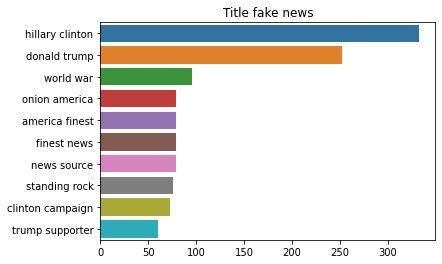

In [ ]:
#Title fake news
top_n_bigrams=get_top_ngram(news_df_false['title_wo_punct'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Title fake news')

[Text(0.5, 1.0, 'Title fake news')]

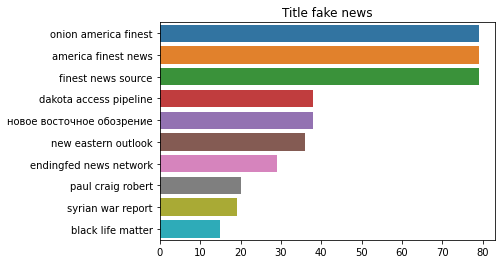

In [ ]:
#Title fake news (3 words)
top_n_bigrams=get_top_ngram(news_df_false['title_wo_punct'],3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Title fake news')

[Text(0.5, 1.0, 'Title true news')]

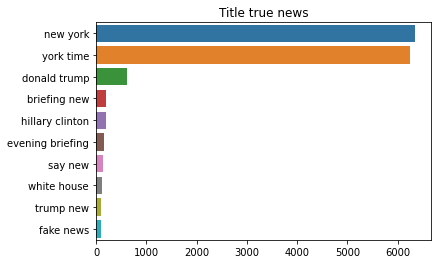

In [ ]:
#Title true news
top_n_bigrams=get_top_ngram(news_df_true['title_wo_punct'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Title true news')

[Text(0.5, 1.0, 'Title true news')]

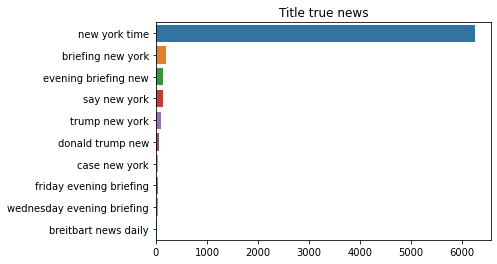

In [ ]:
#Title true news (3 words)
top_n_bigrams=get_top_ngram(news_df_true['title_wo_punct'],3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Title true news')

[Text(0.5, 1.0, 'Text fake news')]

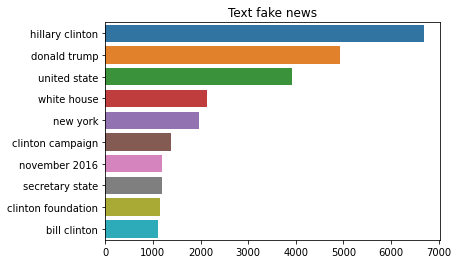

In [ ]:
#Text fake news
top_n_bigrams=get_top_ngram(news_df_false['text_wo_punct'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Text fake news')

[Text(0.5, 1.0, 'Text fake news')]

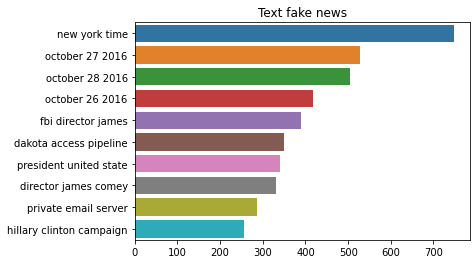

In [ ]:
#Text fake news (3 words)
top_n_bigrams=get_top_ngram(news_df_false['text_wo_punct'],3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Text fake news')

[Text(0.5, 1.0, 'Text true news')]

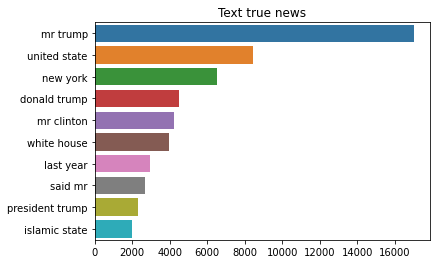

In [ ]:
#Text true news
top_n_bigrams=get_top_ngram(news_df_true['text_wo_punct'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Text true news')

[Text(0.5, 1.0, 'Text true news')]

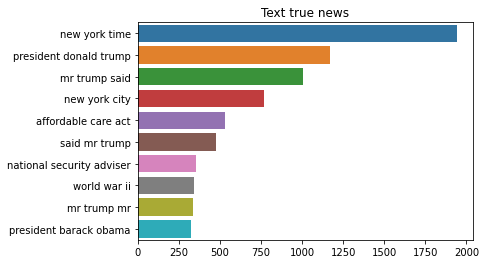

In [ ]:
#Text true news (3 words)
top_n_bigrams=get_top_ngram(news_df_true['text_wo_punct'],3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set(title='Text true news')

Title and text of fake and not fake news is different and the order of the words is also different

In [ ]:
news_df_true['author'].value_counts()

pam key                                  242
jerome hudson                            166
charlie spiering                         141
john hayward                             140
katherine rodriguez                      124
                                        ... 
kenneth chang mike isaac matt richtel      1
cecilia kang michael shear                 1
adam nagourney jonathan martin             1
france roble kirk semple                   1
michael j de la merced rachel abrams       1
Name: author, Length: 2225, dtype: int64

In [ ]:
news_df_false['author'].value_counts()

                           1932
admin                       234
author                      111
pakalert                     86
eddy lavine                  85
                           ... 
jdhank                        1
johnnygl                      1
well                          1
connectdots                   1
judge andrew napolitano       1
Name: author, Length: 1968, dtype: int64

We can see that unknown authors can give fake news

In [ ]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(news_df['text_wo_punct'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
# df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in text news')

said 80008
mr 71386
trump 55876
one 39756
state 37440
would 37232
people 36862
year 31986
time 29989
new 29986
clinton 28103
like 26636
also 25430
president 25391
american 22072
could 19296
many 19192
even 18875
government 17794
country 17604


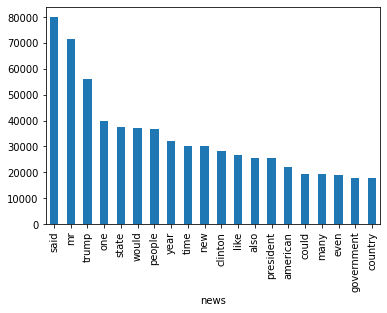

In [ ]:
groups=df1.groupby('news').sum()['count'].sort_values(ascending=False)
groups.plot.bar()

In [ ]:
common_words_true = get_top_n_words(news_df_true['text_wo_punct'], 20)

#Printing the word and frequency
for word, freq in common_words_true:
    print(word, freq)

#Creating the dataframe of word and frequency
common_true = pd.DataFrame(common_words_true, columns = ['news' , 'count'])

mr 69266
said 68171
trump 36177
one 23464
would 22782
state 22541
year 21582
people 20026
new 19661
time 17945
president 17288
like 16345
also 15527
american 12055
could 11890
two 11409
many 11264
first 11001
last 10908
day 10637


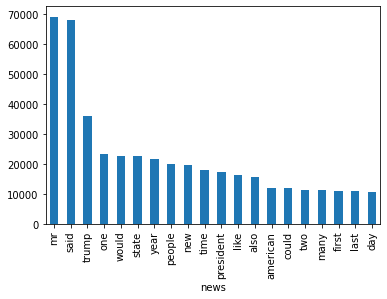

In [ ]:
groups_true=common_true.groupby('news').sum()['count'].sort_values(ascending=False)
groups_true.plot.bar()

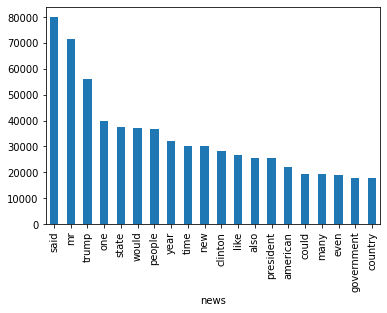

We can see Top 20 words in text news

In [ ]:
# ## **Plot Correlations**
# corr_matrix=news_df.corr()
# plt.figure(figsize=(20,10))
# sns.set(style="whitegrid")
# sns.heatmap(corr_matrix,annot=True,cmap='BrBG_r',annot_kws={"fontsize":12})

In [ ]:
#Save in csv
news_df.to_csv("news_df.csv", index = False)

# 01_content_model

In [151]:
content_features=news_df[['content']].reset_index(drop=True)
content_features.head()
# content_features.info()

,content
0,darrell lucus house dem aide didnt even see co...
1,daniel j flynn flynn hillary clinton big woman...
2,consortiumnewscom truth might get fired
3,jessica purkiss 15 civilian killed single u ai...
4,howard portnoy iranian woman jailed fictional ...


In [152]:
# STEMMING:

# A stemming algorithm is a process of linguistic normalisation, in which the variant forms of a word are reduced to a common form.
# In simple words, Stemming is the process of reducing a word to its Root word.

# EXAMPLES:

# actor, actress, acting --> act
# eating, eats, eaten --> eat
port_stem = PorterStemmer()

def stemming(content):
    review = re.sub('[^a-zA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review


In [153]:
corpus=[]
for i in range (0,len(content_features)):
    review = re.sub('[^a-zA-Z]',' ',content_features['content'][i])
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review) #Getting the target variable

y=news_df['label']

In [154]:
news_df['content'] = news_df['content'].apply(stemming)
print(news_df['content'])

0        darrel lucu hous dem aid didnt even see comey ...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnewscom truth might get fire
3        jessica purkiss civilian kill singl u airstrik...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper ti trump poster child whit...
20796    benjamin hoffman nfl playoff schedul matchup o...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [158]:
#separating the data and label
X = news_df['content'].values
y = news_df['label'].values
print(X)
print(y)

['darrel lucu hous dem aid didnt even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnewscom truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']
[1 0 1 ... 0 1 1]


In [159]:
# TF-IDF stands for “Term Frequency – Inverse Document Frequency ”

# TF-IDF is a numerical statistic which measures the importance of the word in a document.

# Term Frequency : Number of time a word appears in a text document.

# Inverse Document Frequency : Measure the word is a rare word or common word in a document.
# converting the textual data to numerical data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
print(X)

  (0, 15715)	0.27509776674930964
  (0, 13500)	0.24751839165094688
  (0, 8935)	0.34407386324153105
  (0, 8641)	0.2807585463060049
  (0, 7754)	0.23576831817995195
  (0, 7089)	0.2101591116422122
  (0, 4960)	0.2213068725389418
  (0, 4012)	0.2855963683829043
  (0, 3810)	0.25725947050905124
  (0, 3617)	0.34407386324153105
  (0, 2992)	0.23677503959610688
  (0, 2517)	0.3568969629559933
  (0, 260)	0.25988649489467747
  (1, 16824)	0.2683725055199064
  (1, 6895)	0.19932591430863353
  (1, 5563)	0.7220913893708876
  (1, 3584)	0.26783521583674674
  (1, 2836)	0.20020745128848605
  (1, 2259)	0.3723354871367826
  (1, 1940)	0.1569261526606
  (1, 1542)	0.3029045143249354
  (2, 15645)	0.443161566926536
  (2, 9623)	0.5173836673945003
  (2, 6038)	0.3676200487762488
  (2, 5438)	0.4118222937368373
  :	:
  (20797, 13159)	0.25304453797135923
  (20797, 12391)	0.2747303058280698
  (20797, 12187)	0.2463075351450266
  (20797, 10297)	0.08011199406224062
  (20797, 9590)	0.17305533076162702
  (20797, 9524)	0.292544841

In [44]:
X.toarray() 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
vectorizer.get_feature_names()

In [ ]:
X.toarray() 

In [45]:
# SPLITTING THE DATASET INTO TRAINING DATA & TEST DATA:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=2)

In [46]:
# LOGISTIC REGRESSION:
lg = LogisticRegression()
model_lg=lg.fit(X_train, y_train)

# accuracy score on the training data
X_train_prediction = lg.predict(X_train)
training_data_accuracy = round(accuracy_score(X_train_prediction, y_train)*100,3)

print('Accuracy score of the training data,%: ', training_data_accuracy)

Accuracy score of the training data,%:  98.702


In [47]:
#Probablity for fake text on Train data
X_train_prob = lg.predict_proba(X_train)
print(f"Probablity for Fake is:{X_train_prob}")

Probablity for Fake is:[[0.95619942 0.04380058]
 [0.88999611 0.11000389]
 [0.94558502 0.05441498]
 ...
 [0.94812304 0.05187696]
 [0.58451302 0.41548698]
 [0.0651922  0.9348078 ]]


In [48]:
#Probablity for fake text on test data
X_test_prob = lg.predict_proba(X_test)
print(f"Probablity for Fake is:{X_test_prob}")

Probablity for Fake is:[[0.06361302 0.93638698]
 [0.9428651  0.0571349 ]
 [0.03090367 0.96909633]
 ...
 [0.08793311 0.91206689]
 [0.15105928 0.84894072]
 [0.97245462 0.02754538]]


In [49]:
#for Test Model
dt=DecisionTreeClassifier()
knn=KNeighborsClassifier()
nb=MultinomialNB(alpha=0.1) #It is a probabilistic classifier, which means it predicts on the basis of the probability of an object.
dicts = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
models=[lg,dt,knn,nb]

#Printing the accuracy
for i,total in enumerate(models):
    print("{} Test Accuracy: {:.4f}".format(dicts[i],cross_val_score(total, X_test, y_test, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9510
Decision Tree Test Accuracy: 0.9774
KNN Test Accuracy: 0.5077
Naive Bayes Test Accuracy: 0.9435


In [50]:
model_dt=dt.fit(X_train, y_train)
dt_predict=dt.predict(X_train)
model_knn=knn.fit(X_train, y_train)
knn_predict=knn.predict(X_train)
model_nb=nb.fit(X_train, y_train)
nb_predict=nb.predict(X_train)



In [52]:
from sklearn.metrics import mean_squared_error
rmse_lg=mean_squared_error(y_train, X_train_prediction, squared=False)
rmse_dt=mean_squared_error(y_train, dt_predict, squared=False)
rmse_knn=mean_squared_error(y_train, knn_predict, squared=False)
rmse_nb=mean_squared_error(y_train, nb_predict, squared=False)
# rmse_models=[rmse_lg,rmse_dt,rmse_knn, rmse_nb]

print("Logistic Regression RMSE = {:.4f}".format(rmse_lg),'\n'
      "Decision Tree RMSE = {:.4f}".format(rmse_dt),'\n'
      "KNN RMSE = {:.4f}".format(rmse_knn),'\n'
      "Naive Bayes RMSE = {:.4f}".format(rmse_nb)
      )

Logistic Regression RMSE = 0.1139 
Decision Tree RMSE = 0.0380 
KNN RMSE = 0.6823 
Naive Bayes RMSE = 0.0775


In [53]:
#For Train Model
from sklearn.naive_bayes import MultinomialNB
dt=DecisionTreeClassifier()
knn=KNeighborsClassifier()
nb=MultinomialNB(alpha=0.1) 
dicts = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
models=[lg,dt,knn,nb]

#Printing the accuracy
for i,total in enumerate(models):
    print("{} Train Accuracy: {:.4f}".format(dicts[i],cross_val_score(total, X_train, y_train, cv=10, scoring ='accuracy').mean()))

Logistic Regression Train Accuracy: 0.9751
Decision Tree Train Accuracy: 0.9918
KNN Train Accuracy: 0.5205
Naive Bayes Train Accuracy: 0.9703


In [54]:
# CONFUSION MATRIX:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
# accuracy score on the test data
X_test_prediction = lg.predict(X_test)
test_data_accuracy = round(accuracy_score(X_test_prediction, y_test)*100,3)
print('Accuracy score of the test data, % : ', test_data_accuracy)

Accuracy score of the test data, % :  97.981


In [56]:
print(classification_report(y_train,X_train_prediction))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8310
           1       0.98      1.00      0.99      8330

    accuracy                           0.99     16640
   macro avg       0.99      0.99      0.99     16640
weighted avg       0.99      0.99      0.99     16640



In [57]:

print(classification_report(y_test,X_test_prediction))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2077
           1       0.97      0.99      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



In [58]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.33, random_state=42)
# CLASSIFICATION MODEL : MULTINOMIAL NAIVE BAYES

# Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP)

# Multinomial Naïve Bayes uses term frequency i.e. the number of times a given term appears in a document. Term frequency is often normalized by dividing the raw term frequency by the document length

#let's implement the model : Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
from sklearn import metrics
import numpy as np
import itertools

accuracy:   0.971
Confusion matrix, without normalization


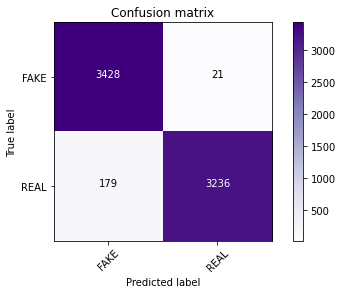

In [59]:
# Test prediction
classifier.fit(X1_train, y1_train)
prediction1 = classifier.predict(X1_test)
score = metrics.accuracy_score(y1_test, prediction1)
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(y1_test, prediction1)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])


accuracy:   0.986
Confusion matrix, without normalization


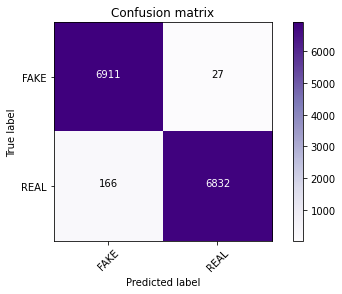

In [60]:
# Train prediction
classifier.fit(X1_train, y1_train)
prediction1 = classifier.predict(X1_train)
score = metrics.accuracy_score(y1_train, prediction1)
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(y1_train, prediction1)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])

accuracy:   0.991
Confusion matrix, without normalization


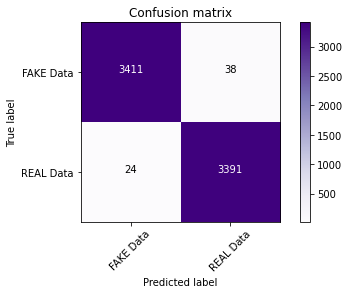

In [61]:
# CLASSIFICATION MODEL : PASSIVE AGGRESSIVE CLASSIFIER

# Passive Aggressive Classifier works by responding as passive for correct classifications and responding as aggressive for any miscalculation.
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.33, random_state=42)
#lets implemet the algorithm : Passive Aggressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)

#Test prediction
linear_clf.fit(X2_train, y2_train)
prediction2 = linear_clf.predict(X2_test)
score = metrics.accuracy_score(y2_test, prediction2)
print("accuracy:   %0.3f" % score)
cm2 = metrics.confusion_matrix(y2_test, prediction2)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(X2_train,y2_train)
#Predict on the test set and calculate accuracy
y_pred=pac.predict(X2_test)
score=accuracy_score(y2_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')



Accuracy: 99.11%


accuracy:   0.999
Confusion matrix, without normalization


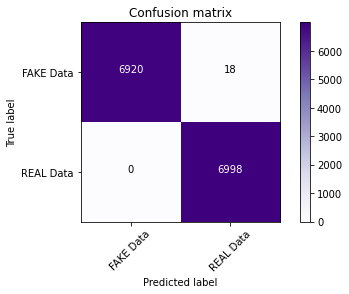

In [63]:
#Train prediction
prediction2 = linear_clf.predict(X2_train)
score = metrics.accuracy_score(y2_train, prediction2)
print("accuracy:   %0.3f" % score)
cm2 = metrics.confusion_matrix(y2_train, prediction2)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

In [64]:
# BUILDING A PREDICTIVE SYSTEM:

# Building a predictive system inorder to find that the inital word in the dataset is real or fake using LogisticRegression model:

X_new = X_test[11]

prediction = lg.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')


[1]
The news is Fake


In [65]:
#Probability for fake or real on every sample
X_prob = X_test[1]

prob = lg.predict_proba(X_prob)
print(f'{prob[0][0]:.2f}')

if (prob[0][0]<0.7):
  print('The news is Real')
else:
  print('The news is Fake')

0.94
The news is Fake


In [66]:
fake_prob = lg.predict_proba(X_test)


In [67]:
prob[0][0]

0.9428651019721619

In [68]:
from sklearn.metrics import log_loss
logloss = log_loss(y_test,fake_prob)
print(logloss)

0.12501963566203195


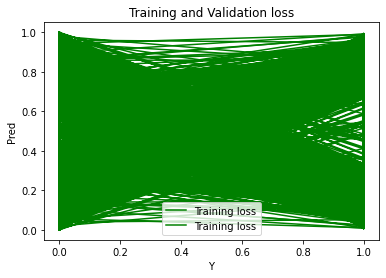

In [69]:
import matplotlib.pyplot as plt
# loss_train = history.history['train_loss']
# loss_val = history.history['val_loss']
plt.plot(y_test, fake_prob, 'g', label='Training loss')
# plt.plot(y_test, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Y')
plt.ylabel('Pred')
plt.legend()
plt.show()


# plt.plot(Y_array, x_entropy_loss, 'r-' )
# plt.title('Cross entropy loss')
# plt.xlabel('$Y_{pred}$', fontsize=15)
# plt.ylabel('$Y_{label}$', fontsize=15)
# plt.ylim(-2, 5)
# plt.show()

In [70]:
submit_test.iloc[11]

id                                                    20811
title                  “Working Class Hero” by John Brennon
author                                         Doug Diamond
text      Source: CNBC, article by Robert Ferris Arctic ...
label                                                     1
Name: 11, dtype: object

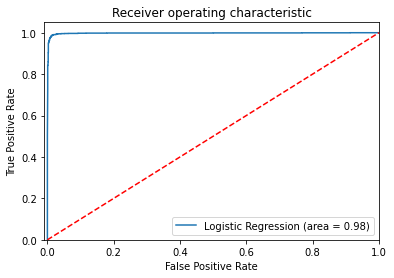

In [71]:
logit_roc_auc = roc_auc_score(y_test, lg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# **Building Sequence Model**

LSTM

In [183]:
# tensorflow.keras.etc is for TF 1.14
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [184]:
#####################
###  PARAMS  ###
#####################
sequence_neuron_size = 100
sent_length=5000
hidden_layer_1 = 32 #a layer in between input layers and output layers
epochs = 20         #a number of complete passes through the training dataset
batch_size = 256    #a number of samples processed before the model is updated.
classifier = 'binary'
voc_size = 10000

In [185]:
#Creating the lstm model
import warnings
warnings.filterwarnings('ignore')
embedding_vector_features=40


model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))


#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


Now let’s train the model.

In [186]:
#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [187]:
#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...  444 7768 7579]
 [   0    0    0 ... 4336 7180 3084]
 [   0    0    0 ... 9830 9075 5577]
 ...
 [   0    0    0 ... 5688 5748 5690]
 [   0    0    0 ... 9166 5097 7680]
 [   0    0    0 ...  896 3180 6057]]


In [188]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((20800, 5000), (20800,))

In [189]:
# Train test split of the X and y final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
history=model.fit(X_train_final,y_train_final,validation_data=(X_test_final,y_test_final),epochs=5,batch_size=64)

Epoch 1/5
218/218 [==============================] - 61s 245ms/step - loss: 0.2446 - accuracy: 0.8935 - val_loss: 0.0639 - val_accuracy: 0.9819
Epoch 2/5
218/218 [==============================] - 52s 238ms/step - loss: 0.0314 - accuracy: 0.9917 - val_loss: 0.0420 - val_accuracy: 0.9899
Epoch 3/5
218/218 [==============================] - 52s 238ms/step - loss: 0.0461 - accuracy: 0.9892 - val_loss: 0.0527 - val_accuracy: 0.9857
Epoch 4/5
218/218 [==============================] - 52s 238ms/step - loss: 0.0173 - accuracy: 0.9968 - val_loss: 0.0534 - val_accuracy: 0.9854
Epoch 5/5
218/218 [==============================] - 52s 238ms/step - loss: 0.0137 - accuracy: 0.9981 - val_loss: 0.0499 - val_accuracy: 0.9872


In [190]:
score = model.evaluate(X_test_final, y_test_final, verbose=0)
print('\nScore:', score)


Score: [0.04990658909082413, 0.9871794581413269]


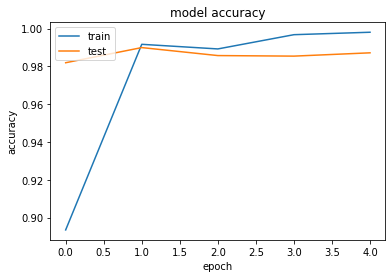

In [191]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

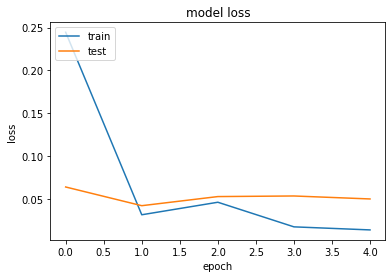

In [192]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Check accuracy on test data

In [193]:
y_check = model.predict(X_test_final)
y_check 

array([[9.9900216e-01],
       [9.9877220e-01],
       [5.0262839e-05],
       ...,
       [1.5139111e-03],
       [9.8248722e-07],
       [8.3963285e-05]], dtype=float32)

In [194]:
# Convert scientific values to true or false 

y_check=(y_check>0.5)
y_check=y_check.reshape(-1,)
y_check

array([ True,  True, False, ..., False, False, False])

In [195]:
# Convert true or false to labels

le=LabelEncoder()
y_check=le.fit_transform(y_check)
y_check

array([1, 1, 0, ..., 0, 0, 0])

In [196]:
#y_pred= model.predict(X_test).astype("int32")
#y_pred=np.argmax(model.predict(X_test), axis=-1)
confusion_matrix(y_test_final, y_check)

array([[3417,   32],
       [  56, 3359]])

In [197]:
accuracy_score(y_test_final, y_check)

0.9871794871794872

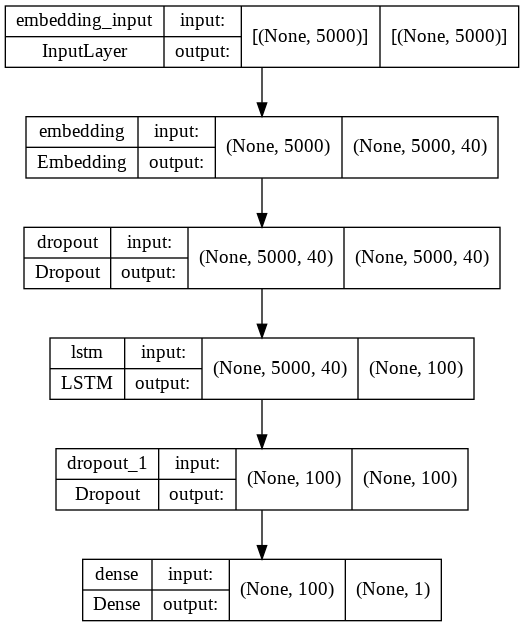

In [199]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Keras Tokenizer 

In [ ]:
# Imports
from keras.initializers import Constant
import spacy
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

def tokenize_padder(train_text, test_text,
                   chars_to_filter = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                    oov_token = "OOV",
                    maxlen = 500,
                    padding = "pre",
                    truncating = "post"
                   ):
    # Create tokenizer
    tokenizer = Tokenizer(filters = chars_to_filter,
                          oov_token = oov_token)

    # Fit tokenizer on training data only
    tokenizer.fit_on_texts(train_text)

    # Generate sequences
    train_sequences = tokenizer.texts_to_sequences(train_text)
    test_sequences = tokenizer.texts_to_sequences(test_text)

    # Pad and trim sequences
    # Pre-padding is empirically better for sequence modelling
    # Post-truncating ensures the titles are included in observations
    train_padded = pad_sequences(train_sequences, maxlen = maxlen, padding = padding, truncating = truncating)
    test_padded = pad_sequences(test_sequences, maxlen = maxlen, padding = padding, truncating = truncating)

    return tokenizer, train_padded, test_padded

# Split into test and train data
X = news_df.content.values
y = np.array(news_df["label"], dtype = "float32")
text_train, text_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, shuffle = True,
                                                          # reproducible split
                                                         random_state = 1)
# Process, tokenize, pad/trim
tokenizer, X_train, X_test = tokenize_padder(text_train, text_test)

In [ ]:
# CNN
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.models import Sequential

In [ ]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same', activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(Dropout(0.2))

In [ ]:
# model.add(layers.Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(10,activation = "softmax"))

In [ ]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [ ]:
# input_shape = X_train_final.shape  
#  model.build() 

In [ ]:
# model.summary()

# 02_models on full dataframe

In [160]:
total_df.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


In [161]:
total_df=total_df.drop(['id'],axis=1)


In [162]:
total_df['all_news'] = total_df['content']+' '+total_df['text']

In [170]:
text_features_1 = total_df[['all_news']].reset_index(drop=True)
text_features_1.head()

,all_news
0,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,Consortiumnews.com Why the Truth Might Get You...
3,Jessica Purkiss 15 Civilians Killed In Single ...
4,Howard Portnoy Iranian woman jailed for fictio...


In [171]:
port_stem = PorterStemmer()

def stemming(text_wo_punct):
    review = re.sub('[^a-zA-Z]',' ',text_wo_punct)
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

In [166]:
total_df['all_news'] =total_df['all_news'].apply(str)

In [172]:
corpus_all=[]
for i in range (0,len(text_features_1)):
    review = re.sub('[^a-zA-Z]',' ',text_features_1['all_news'][i])
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_all.append(review) #Getting the target variable

y_all=total_df['label']

In [173]:
total_df['all_news']=total_df['all_news'].apply(str)

In [174]:
total_df['all_news']=total_df['all_news'].apply(stemming)

In [ ]:
print(total_df['all_news'])

0        darrel lucu hous dem aid didnt even see comey ...
1        daniel j flynn flynn hillari clinton big woman...
2        consortiumnewscom truth might get fire truth m...
3        jessica purkiss civilian kill singl u airstrik...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper ti trump poster child whit...
20796    benjamin hoffman nfl playoff schedul matchup o...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799    david swanson keep f aliv david swanson author...
Name: all_news, Length: 20800, dtype: object


In [175]:
total_df=total_df[['all_news','label']]
total_df

,all_news,label
0,darrel lucu hous dem aid even see comey letter...,1
1,daniel j flynn flynn hillari clinton big woman...,0
2,consortiumnew com truth might get fire truth m...,1
3,jessica purkiss civilian kill singl us airstri...,1
4,howard portnoy iranian woman jail fiction unpu...,1
...,...,...
20795,jerom hudson rapper trump poster child white s...,0
20796,benjamin hoffman n f l playoff schedul matchup...,0
20797,michael j de la merc rachel abram maci said re...,0
20798,alex ansari nato russia hold parallel exercis ...,1


In [176]:
#separating the data and label
X_all = total_df["all_news"].values
Y_all = total_df['label'].values
print(X_all)
# print(Y_all)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet hous dem aid even see comey letter jason chaffetz tweet darrel lucu octob subscrib jason chaffetz stump american fork utah imag courtesi michael jolley avail creativ common licens apolog keith olbermann doubt worst person world week fbi director jame comey accord hous democrat aid look like also know second worst person well turn comey sent infam letter announc fbi look email may relat hillari clinton email server rank democrat relev committe hear comey found via tweet one republican committe chairmen know comey notifi republican chairmen democrat rank member hous intellig judiciari oversight committe agenc review email recent discov order see contain classifi inform long letter went oversight committe chairman jason chaffetz set polit world ablaz tweet fbi dir inform fbi learn exist email appear pertin investig case reopen jason chaffetz jasoninthehous octob cours know case comey actual say review email light unrel 

In [ ]:
# X_all = str(X_all).lower()
# X_all

In [177]:
# TF-IDF stands for “Term Frequency – Inverse Document Frequency ”

# TF-IDF is a numerical statistic which measures the importance of the word in a document.

# Term Frequency : Number of time a word appears in a text document.

# Inverse Document Frequency : Measure the word is a rare word or common word in a document.
# converting the textual data to numerical data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_all)
X_all = vectorizer.transform(X_all)
print(X_all)

  (0, 103542)	0.048451941775463823
  (0, 103495)	0.019716731083867973
  (0, 102585)	0.044400215358678725
  (0, 102581)	0.09517212979652764
  (0, 102538)	0.038633690592775376
  (0, 102503)	0.011569200764591567
  (0, 101885)	0.017358552515456645
  (0, 101113)	0.017236407149263697
  (0, 101024)	0.012852354835488227
  (0, 100943)	0.029592084850644428
  (0, 100871)	0.013020916657451274
  (0, 100686)	0.012017077893826483
  (0, 99894)	0.025583359548369523
  (0, 99860)	0.03203364688566499
  (0, 98937)	0.021708384639417655
  (0, 97643)	0.0649458379077005
  (0, 96993)	0.03309474868126314
  (0, 96749)	0.016460873462438002
  (0, 96000)	0.03773020623167838
  (0, 95396)	0.01133144897403739
  (0, 95387)	0.043190573905675995
  (0, 95335)	0.136582142067406
  (0, 95196)	0.07223192004861546
  (0, 93994)	0.03914396987142587
  (0, 93460)	0.02693174715943784
  :	:
  (20799, 7004)	0.010816505487943126
  (20799, 6696)	0.028298989257253503
  (20799, 6418)	0.039621221280019575
  (20799, 6380)	0.0252853313900795

In [178]:
# SPLITTING THE DATASET INTO TRAINING DATA & TEST DATA:

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size = 0.2, stratify=y, random_state=2)

In [179]:
# LOGISTIC REGRESSION:
lg = LogisticRegression()
lg.fit(X_all_train, y_all_train)

# accuracy score on the training data
X_all_train_prediction = lg.predict(X_all_train)
training_data_accuracy = round(accuracy_score(X_all_train_prediction, y_all_train)*100,3)

print('Accuracy score of the training data,%: ', training_data_accuracy)

Accuracy score of the training data,%:  98.155


In [180]:
#for Test Model
dt=DecisionTreeClassifier()
knn=KNeighborsClassifier()
nb=MultinomialNB(alpha=0.1) #It is a probabilistic classifier, which means it predicts on the basis of the probability of an object.
dicts = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
models=[lg,dt,knn,nb]

#Printing the accuracy
for i,total in enumerate(models):
    print("{} Test Accuracy: {:.4}".format(dicts[i],cross_val_score(total, X_test, y_test, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.951
Decision Tree Test Accuracy: 0.9764
KNN Test Accuracy: 0.5077
Naive Bayes Test Accuracy: 0.9435


In [181]:
#For Train Model
from sklearn.naive_bayes import MultinomialNB
dt=DecisionTreeClassifier()
knn=KNeighborsClassifier()
nb=MultinomialNB(alpha=0.1) 
dicts = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
models=[lg,dt,knn,nb]

#Printing the accuracy
for i,total in enumerate(models):
    print("{} Train Accuracy: {:.4}".format(dicts[i],cross_val_score(total, X_train, y_train, cv=10, scoring ='accuracy').mean()))

Logistic Regression Train Accuracy: 0.9751
Decision Tree Train Accuracy: 0.9921
KNN Train Accuracy: 0.5205
Naive Bayes Train Accuracy: 0.9703


# 03_model without changed in the text

In [72]:
news.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


In [73]:
# replacing the null values with empty string
news = news.fillna('')
# checking the number of missing values in the dataset
news.isnull().sum()

id         0
title      0
author     0
text       0
label      0
content    0
dtype: int64

In [74]:

news['content_new'] = news['author']+' '+news['title']
news.head()

,id,title,author,text,label,content,content_new
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...","Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...,Howard Portnoy Iranian woman jailed for fictio...


In [75]:
#separating the data and label
X_new = news['content_new'].values
y_new = news['label'].values
print(X_new)
print(y_new)

['Darrell Lucus House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'
 'Daniel J. Flynn FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'
 'Consortiumnews.com Why the Truth Might Get You Fired' ...
 'Michael J. de la Merced and Rachel Abrams Macy’s Is Said to Receive Takeover Approach by Hudson’s Bay - The New York Times'
 'Alex Ansary NATO, Russia To Hold Parallel Exercises In Balkans'
 'David Swanson What Keeps the F-35 Alive']
[1 0 1 ... 0 1 1]


In [76]:
# TF-IDF stands for “Term Frequency – Inverse Document Frequency ”

# TF-IDF is a numerical statistic which measures the importance of the word in a document.

# Term Frequency : Number of time a word appears in a text document.

# Inverse Document Frequency : Measure the word is a rare word or common word in a document.
# converting the textual data to numerical data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_new)
X_new = vectorizer.transform(X_new)
print(X_new)

  (0, 23355)	0.18006497451107856
  (0, 22649)	0.26575278886038384
  (0, 22289)	0.3484071341454308
  (0, 19171)	0.22537992364975484
  (0, 12902)	0.3024224900242886
  (0, 12528)	0.24883399099107747
  (0, 11409)	0.20615188166061463
  (0, 11307)	0.1532265401605094
  (0, 10387)	0.1844880289323935
  (0, 7574)	0.23047267305353566
  (0, 6145)	0.24677171892553343
  (0, 5800)	0.2502787762405247
  (0, 5508)	0.2993429551929777
  (0, 4507)	0.20531415441295317
  (0, 3862)	0.30579573877221844
  (0, 904)	0.26354004814013343
  (1, 23748)	0.2966210296019264
  (1, 15149)	0.15862263711495958
  (1, 10134)	0.18787145765749733
  (1, 8420)	0.7045992054867243
  (1, 5469)	0.2624012615566619
  (1, 4298)	0.19024289659874757
  (1, 3509)	0.37751839443307017
  (1, 3075)	0.15310531118537438
  (1, 2544)	0.2899843833664323
  :	:
  (20797, 11262)	0.12516633187998083
  (20797, 10427)	0.20792477683235197
  (20797, 5559)	0.20389975589596085
  (20797, 3394)	0.14456424605079038
  (20797, 2273)	0.31989436828531154
  (20797, 1

In [77]:
# # Select the first five documents from the data set
# tf_idf = pd.DataFrame(vectors.todense()).iloc[:5]  
# tf_idf.columns = vectorizer.get_feature_names()
# tfidf_matrix = tf_idf.T
# tfidf_matrix.columns = ['response'+ str(i) for i in range(1, 6)]
# tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

# # Top 10 words 
# tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)[:10] 

# # Print the first 10 words 
# print(tfidf_matrix.drop(columns=['count']).head(10))

In [78]:
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)

In [79]:
#for Test Model
lg_new=LogisticRegression()
lg_new.fit(Xnew_train,ynew_train)
dt_new=DecisionTreeClassifier()
knn_new=KNeighborsClassifier()
nb_new=MultinomialNB(alpha=0.1) #It is a probabilistic classifier, which means it predicts on the basis of the probability of an object.
dicts = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
models_new=[lg_new,dt_new,knn_new,nb_new]

#Printing the accuracy
for i,total in enumerate(models_new):
    print("{} Test Accuracy: {:.4f}".format(dicts[i],cross_val_score(total, Xnew_test, ynew_test, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9548
Decision Tree Test Accuracy: 0.9846
KNN Test Accuracy: 0.9079
Naive Bayes Test Accuracy: 0.9311


In [80]:
#for Train Model
lg_new=LogisticRegression()
lg_new.fit(Xnew_train,ynew_train)
dt_new=DecisionTreeClassifier()
knn_new=KNeighborsClassifier()
nb_new=MultinomialNB(alpha=0.1) #It is a probabilistic classifier, which means it predicts on the basis of the probability of an object.
dicts = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
models_new=[lg_new,dt_new,knn_new,nb_new]

#Printing the accuracy
for i,total in enumerate(models_new):
    print("{} Train Accuracy: {:.4f}".format(dicts[i],cross_val_score(total, Xnew_train, ynew_train, cv=10, scoring ='accuracy').mean()))

Logistic Regression Train Accuracy: 0.9721
Decision Tree Train Accuracy: 0.9934
KNN Train Accuracy: 0.9331
Naive Bayes Train Accuracy: 0.9493


In [81]:
model_lg_new=lg_new.fit(Xnew_train,ynew_train)
lg_new_predict=lg_new.predict(Xnew_train)
model_dt_new=dt.fit(Xnew_train,ynew_train)
dt_predict_new=dt.predict(Xnew_train)
model_knn_new=knn.fit(Xnew_train, ynew_train)
knn_predict_new=knn.predict(Xnew_train)
model_nb_new=nb.fit(Xnew_train,ynew_train)
nb_predict_new=nb.predict(Xnew_train)

In [82]:
from sklearn.metrics import mean_squared_error
rmse_lg=mean_squared_error(ynew_train, lg_new_predict, squared=False)
rmse_dt=mean_squared_error(ynew_train, dt_predict_new, squared=False)
rmse_knn=mean_squared_error(ynew_train, knn_predict_new, squared=False)
rmse_nb=mean_squared_error(ynew_train, nb_predict_new, squared=False)
# rmse_models=[rmse_lg,rmse_dt,rmse_knn, rmse_nb]

print("Logistic Regression RMSE = {:.4f}".format(rmse_lg),'\n'
      "Decision Tree RMSE = {:.4f}".format(rmse_dt),'\n'
      "KNN RMSE = {:.4f}".format(rmse_knn),'\n'
      "Naive Bayes RMSE = {:.4f}".format(rmse_nb)
      )

Logistic Regression RMSE = 0.1198 
Decision Tree RMSE = 0.0000 
KNN RMSE = 0.1972 
Naive Bayes RMSE = 0.0896
